# ESGF Virtual Aggregation - Global Surface Air Temperature changes in future scenarios

> This notebook is a reproducibility example of the IPCC-WGI AR6 Interactive Atlas products, which has been adapted to work with the ESGF Virtual Aggregation. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

**E. Cimadevilla** (Santander Meteorology Group. Instituto de Física de Cantabria, CSIC-UC, Santander, Spain).

This notebook computes Global Surface Air Temperature (GSAT) changes relative to the 1995–2014 and 1850–1900 averages, according to CMIP6 climate models.

This notebook works with data available in the ESGF, which is accessed in a **remote data access** fashion through virtual aggregations provided by the [ESGF Virtual Aggregation](https://doi.org/10.5194/gmd-2024-120).

In [1]:
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cftime

import xarray
import dask

In [2]:
dask.config.set(scheduler="processes")

## 1. Data loading

To locate the data in which we are interested, we use the CSV inventory of the ESGF Virtual Aggregation. We will analyze the inventory using standard Pandas functionality. The data will be loaded in a remote data access fashion via OPeNDAP provided by a THREDDS Data Server.

The versions of the ESGF datasets in which we are interested are available in the `atlas-tas.csv` file provided in this same directory. These versions were extracted from the [IPCC-WGI/Atlas GitHub repository](https://raw.githack.com/IPCC-WG1/Atlas/devel/data-sources/CMIP6/CMIP6.html).

In [3]:
esgf_va_catalog = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip").fillna("")
atlas_ipcc_catalog = pd.read_csv("atlas-tas.csv")
model_runs = atlas_ipcc_catalog[["model", "member"]].set_index("model").to_dict()["member"]

/tmp/ipykernel_2450159/3325839039.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  esgf_va_catalog = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip").fillna("")


The following function manages the locations of the datasets from the ESGF Virtual Aggregation that we are interested in. Since some versions are no longer available on the ESGF—having been replaced by newer versions—not all of the original datasets will be loaded.

In [4]:
def find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, experiment):
    ignored_models = [
        "EC-Earth3", # missing file at CEDA
        "EC-Earth3-Veg", # replica unavailable
        "MIROC-ES2L", # no replica seems to work
        "BCC-CSM2-MR", # no replica seems to work
        "FGOALS-g3", # time series split across different versions
        "KACE-1-0-G", # unavailable
        "NESM3", # bad time coord

        # not available at IA
        "KIOST-ESM",
        "MPI-ESM-1-2-HAM",
        # not available later for Pangeo
        "ACCESS-CM2",
        "ACCESS-ESM1-5",
    ]
    
    preferred_replicas = {
        "historical": {
            "HadGEM3-GC31-LL": "", # esgf-data04.diasjp.net netcdf-java error, ...
            "UKESM1-0-LL": "",
        },
        "ssp126": {
            "HadGEM3-GC31-LL": "",
            "UKESM1-0-LL": "",
        },
        "ssp245": {
            "HadGEM3-GC31-LL": "",
            "UKESM1-0-LL": "",
        },
        "ssp370": {
            "HadGEM3-GC31-LL": "",
            "UKESM1-0-LL": "",
        },
        "ssp585": {
            "HadGEM3-GC31-LL": "",
            "UKESM1-0-LL": "",
        },
    }
    
    esgf_va_model_runs = []
    for model in model_runs:
        if model in ignored_models:
            continue
    
        esgf_va_subset = esgf_va_catalog.query(f"project == 'CMIP6' & model == '{model}' & table == 'day' & variable == 'tas' & experiment == '{experiment}'").set_index(["project", "model", "experiment", "version"]).drop(["variable"], axis=1)
        atlas_ipcc_subset = atlas_ipcc_catalog.drop(["variable"], axis=1)
        
        subset = esgf_va_subset.join(atlas_ipcc_subset.set_index(["project", "model", "experiment", "version"]), on=["project", "model", "experiment", "version"], how="inner")
        if len(subset) > 0:
            # Choose the preferred replica or default to esgf.ceda.ac.uk
            if model in preferred_replicas[experiment]:
                replica = preferred_replicas[experiment][model]
            else:
                replica = "esgf.ceda.ac.uk"
    
            # Probe if the required model member is included in the esgf-va
            print(model)
            subset.to_csv("subset.csv", index=False)
            url = subset[subset["replica"] == replica]["location"].iloc[0]
            print(url)
            ds = xarray.open_dataset(
                url,
                decode_times=False,
                drop_variables=["tracking_id", "further_info_url", "time_bnds", "lat_bnds", "lon_bnds"])
    
            if model_runs[model].encode("ascii") in ds["variant_label"].values:
                record = {"url": url, "model_run": model + "_" + model_runs[model]}
                esgf_va_model_runs.append(record)

    return pd.DataFrame.from_records(esgf_va_model_runs)

Locate the datasets for both the historical and future scenarios.

In [5]:
ssp126_model_runs = find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, "ssp126").set_index("model_run").rename({"url": "ssp126"}, axis=1)
ssp245_model_runs = find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, "ssp245").set_index("model_run").rename({"url": "ssp245"}, axis=1)
ssp370_model_runs = find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, "ssp370").set_index("model_run").rename({"url": "ssp370"}, axis=1)
ssp585_model_runs = find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, "ssp585").set_index("model_run").rename({"url": "ssp585"}, axis=1)
historical_model_runs = find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, "historical").set_index("model_run").rename({"url": "historical"}, axis=1)

AWI-CM-1-1-MR
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_AWI_AWI-CM-1-1-MR_ssp126_day_gn_v20190529/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_AWI_AWI-CM-1-1-MR_ssp126_day_tas_gn_v20190529.ncml
CAMS-CSM1-0
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CAMS_CAMS-CSM1-0_ssp126_day_gn_v20191106/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CAMS_CAMS-CSM1-0_ssp126_day_tas_gn_v20191106.ncml
CMCC-CM2-SR5
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CMCC_CMCC-CM2-SR5_ssp126_day_gn_v20200717/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CMCC_CMCC-CM2-SR5_ssp126_day_tas_gn_v20200717.ncml
CNRM-CM6-1
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp126_day_gr_v20190219/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp126_day_tas_gr_v20190219.ncml
CNRM-ESM2-1
http

/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


CMCC-CM2-SR5
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CMCC_CMCC-CM2-SR5_ssp585_day_gn_v20200622/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CMCC_CMCC-CM2-SR5_ssp585_day_tas_gn_v20200622.ncml
CNRM-CM6-1
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp585_day_gr_v20190219/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp585_day_tas_gr_v20190219.ncml
CNRM-CM6-1-HR
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1-HR_ssp585_day_gr_v20191202/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1-HR_ssp585_day_tas_gr_v20191202.ncml
CNRM-ESM2-1
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp585_day_gr_v20191021/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp585_day_tas_

/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


CMCC-CM2-SR5
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CMCC_CMCC-CM2-SR5_historical_day_gn_v20200616/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CMCC_CMCC-CM2-SR5_historical_day_tas_gn_v20200616.ncml
CNRM-CM6-1
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1_historical_day_gr_v20180917/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1_historical_day_tas_gr_v20180917.ncml
CNRM-CM6-1-HR
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1-HR_historical_day_gr_v20191021/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1-HR_historical_day_tas_gr_v20191021.ncml
CNRM-ESM2-1
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CNRM-CERFACS_CNRM-ESM2-1_historical_day_gr_v20181206/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CNRM-CERFACS_CNRM-ESM2-1_historical_day_tas_gr_v20181206.ncml
GFDL-CM4
https://hub.ipcc.ifca.es/

We now create a DataFrame containing all the available datasets.

In [6]:
df = historical_model_runs.join(
    ssp585_model_runs).join(
    ssp126_model_runs).join(
    ssp245_model_runs).join(
    ssp370_model_runs)
df

,historical,ssp585,ssp126,ssp245,ssp370
model_run,,,,,
AWI-CM-1-1-MR_r1i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...
CAMS-CSM1-0_r2i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...
CanESM5_r1i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN,NaN,NaN
CESM2-WACCM_r1i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN,NaN,NaN
CMCC-CM2-SR5_r1i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...
CNRM-CM6-1_r1i1p1f2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...
CNRM-CM6-1-HR_r1i1p1f2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN,NaN,NaN
CNRM-ESM2-1_r1i1p1f2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...
GFDL-CM4_r1i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN,NaN,NaN,NaN


Show the number of available members for each scenario.

In [7]:
(~df.isna()).sum()

historical    23
ssp585        14
ssp126        12
ssp245         9
ssp370        10
dtype: int64

Load the datasets.

In [8]:
def load_datasets(locations, members, experiment):
    dss = []
    for location in locations:
        if location is np.nan:
            continue
        
        name = location.split("/")[-1]
        model = name.split("_")[3]

        ds = xarray.open_dataset(
            location,
            drop_variables=["tracking_id", "further_info_url", "time_bnds", "lat_bnds", "lon_bnds"]).sel(
            variant_label=members[model].encode("ascii"))

        if experiment.startswith("ssp"):
            ds = ds.isel(time=slice(None, 31390))
            # limit to 2100, avoid cf time indexing issues
            if isinstance(ds["time"][0].item(), cftime.Datetime360Day):
                ds = ds.sel(time=slice("20150101", "20991230"))
            else:
                ds = ds.sel(time=slice("20150101", "20991231"))
        elif experiment == "historical":
            pass
        else:
            raise ValueError("Invalid experiment... exiting")
    
        # add the model_run global attribute
        ds.attrs["model_run"] = f"{model}_{members[model]}"
        dss.append(ds)

    return dss

Open the datasets using [xarray](https://docs.xarray.dev/en/stable/).

In [9]:
historical_dss = load_datasets(df["historical"], model_runs, "historical")
ssp126_dss = load_datasets(df["ssp126"], model_runs, "ssp126")
ssp245_dss = load_datasets(df["ssp245"], model_runs, "ssp245")
ssp370_dss = load_datasets(df["ssp370"], model_runs, "ssp370")
ssp585_dss = load_datasets(df["ssp585"], model_runs, "ssp585")

/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/tmp/ipykernel_2450159/2103017150.py:10: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xarray.open_dataset(
/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Print size of the datasets:

In [10]:
for ds in historical_dss:
    print(f'{ds["tas"].size * ds["tas"].dtype.itemsize / 2**20:.2f} MB')

16949.53 MB
11770.51 MB
1882.03 MB
12703.92 MB
12703.71 MB
7533.12 MB
59588.20 MB
7533.12 MB
11909.73 MB
11909.73 MB
6264.84 MB
4149.17 MB
4962.39 MB
4962.39 MB
4733.95 MB
7533.12 MB
16949.53 MB
4237.38 MB
11770.51 MB
3175.93 MB
12703.71 MB
12703.71 MB
6264.84 MB


In [11]:
for ds in ssp126_dss:
    print(f'{ds["tas"].size * ds["tas"].dtype.itemsize / 2**20:.2f} MB')

8731.69 MB
6063.67 MB
6544.34 MB
3880.75 MB
3880.75 MB
6135.31 MB
2137.44 MB
2438.73 MB
3880.75 MB
8731.69 MB
2182.92 MB
3227.34 MB


In [12]:
for ds in ssp245_dss:
    print(f'{ds["tas"].size * ds["tas"].dtype.itemsize / 2**20:.2f} MB')

8731.69 MB
6063.67 MB
6544.34 MB
3880.75 MB
2137.44 MB
2438.73 MB
8731.69 MB
6063.67 MB
3227.34 MB


In [13]:
for ds in ssp370_dss:
    print(f'{ds["tas"].size * ds["tas"].dtype.itemsize / 2**20:.2f} MB')

8731.69 MB
6063.67 MB
6544.34 MB
3880.75 MB
3880.75 MB
2112.31 MB
2438.73 MB
8731.69 MB
6063.67 MB
3227.34 MB


In [14]:
for ds in ssp585_dss:
    print(f'{ds["tas"].size * ds["tas"].dtype.itemsize / 2**20:.2f} MB')

8731.69 MB
6063.67 MB
969.53 MB
6544.34 MB
6544.34 MB
3880.75 MB
30697.34 MB
3880.75 MB
3227.34 MB
2137.44 MB
2438.73 MB
8731.69 MB
1636.08 MB
6544.34 MB


- Historical - 227 GB, Wall time: 1h 59min 6s
- Historical (subset) - 1 hour 1 min 19s
- Scenarios - ~200 GB (all), Wall times:
    - 29min 56s
    - 22min 38s
    - 24min 29s
    - 40min 38s

In [56]:
%%time

historical_spatial_mean_1995_2014 = []
historical_spatial_mean_1850_1900 = []
for ds in historical_dss:
    print(f"Model_run: {ds.attrs['model_run']}")
    if isinstance(ds["time"][0].item(), cftime.Datetime360Day):
        mean_1995_2014 = ds["tas"].chunk({"time": 100}).sel(time=slice("19950101", "20141230")).mean(["time", "lat", "lon"]).compute(num_workers=8, scheduler="processes")
        mean_1850_1900 = ds["tas"].chunk({"time": 100}).sel(time=slice("18500101", "19001230")).mean(["time", "lat", "lon"]).compute(num_workers=8, scheduler="processes")
    else:
        mean_1995_2014 = ds["tas"].chunk({"time": 100}).sel(time=slice("19950101", "20141231")).mean(["time", "lat", "lon"]).compute(num_workers=8, scheduler="processes")
        mean_1850_1900 = ds["tas"].chunk({"time": 100}).sel(time=slice("18500101", "19001231")).mean(["time", "lat", "lon"]).compute(num_workers=8, scheduler="processes")

    historical_spatial_mean_1995_2014.append(mean_1995_2014)
    historical_spatial_mean_1850_1900.append(mean_1850_1900)

Model_run: AWI-CM-1-1-MR_r1i1p1f1
Model_run: CAMS-CSM1-0_r2i1p1f1
Model_run: CanESM5_r1i1p1f1
Model_run: CESM2-WACCM_r1i1p1f1
Model_run: CMCC-CM2-SR5_r1i1p1f1
Model_run: CNRM-CM6-1_r1i1p1f2
Model_run: CNRM-CM6-1-HR_r1i1p1f2
Model_run: CNRM-ESM2-1_r1i1p1f2
Model_run: GFDL-CM4_r1i1p1f1
Model_run: GFDL-ESM4_r1i1p1f1
Model_run: HadGEM3-GC31-LL_r1i1p1f3
Model_run: IITM-ESM_r1i1p1f1
Model_run: INM-CM4-8_r1i1p1f1
Model_run: INM-CM5-0_r1i1p1f1
Model_run: IPSL-CM6A-LR_r1i1p1f1
Model_run: MIROC6_r1i1p1f1
Model_run: MPI-ESM1-2-HR_r1i1p1f1
Model_run: MPI-ESM1-2-LR_r1i1p1f1
Model_run: MRI-ESM2-0_r1i1p1f1
Model_run: NorESM2-LM_r1i1p1f1
Model_run: NorESM2-MM_r1i1p1f1
Model_run: TaiESM1_r1i1p1f1
Model_run: UKESM1-0-LL_r1i1p1f2
CPU times: user 53.9 s, sys: 2.33 s, total: 56.2 s
Wall time: 45min 40s


Concatenate the results into a single `DataArray`.

In [57]:
%%time

ssp126_spatial_mean = []
for ds in ssp126_dss:
    spatial_mean = ds["tas"].chunk({"time": 100}).mean(["lat", "lon"]).compute(num_workers=8, scheduler="processes")
    spatial_mean = spatial_mean.convert_calendar("gregorian", align_on="year")
    spatial_mean = spatial_mean.isel(time=~pd.to_datetime(spatial_mean["time"].values, errors="coerce").isna())
    spatial_mean["time"] = spatial_mean["time"].astype("datetime64[ns]")
    ssp126_spatial_mean.append(spatial_mean)

CPU times: user 21.8 s, sys: 515 ms, total: 22.3 s
Wall time: 22min


In [ ]:
%%time

ssp245_spatial_mean = []
for ds in ssp245_dss:
    spatial_mean = ds["tas"].chunk({"time": 100}).mean(["lat", "lon"]).compute(num_workers=8, scheduler="processes")
    spatial_mean = spatial_mean.convert_calendar("gregorian", align_on="year")
    spatial_mean = spatial_mean.isel(time=~pd.to_datetime(spatial_mean["time"].values, errors="coerce").isna())
    spatial_mean["time"] = spatial_mean["time"].astype("datetime64[ns]")
    ssp245_spatial_mean.append(spatial_mean)

In [ ]:
%%time

ssp370_spatial_mean = []
for ds in ssp370_dss:
    spatial_mean = ds["tas"].chunk({"time": 100}).mean(["lat", "lon"]).compute(num_workers=8, scheduler="processes")
    spatial_mean = spatial_mean.convert_calendar("gregorian", align_on="year")
    spatial_mean = spatial_mean.isel(time=~pd.to_datetime(spatial_mean["time"].values, errors="coerce").isna())
    spatial_mean["time"] = spatial_mean["time"].astype("datetime64[ns]")
    ssp370_spatial_mean.append(spatial_mean)

In [ ]:
%%time

ssp585_spatial_mean = []
for ds in ssp585_dss:
    spatial_mean = ds["tas"].chunk({"time": 100}).mean(["lat", "lon"]).compute(num_workers=8, scheduler="processes")
    spatial_mean = spatial_mean.convert_calendar("gregorian", align_on="year")
    spatial_mean = spatial_mean.isel(time=~pd.to_datetime(spatial_mean["time"].values, errors="coerce").isna())
    spatial_mean["time"] = spatial_mean["time"].astype("datetime64[ns]")

    ref = np.datetime64("2015-01-01T12:00:00").astype("datetime64[ns]").astype(int)
    spatial_mean["time"] = spatial_mean["time"] + (ref - spatial_mean["time"][0].item())
    
    ssp585_spatial_mean.append(spatial_mean)

Concatenate the results into `DataArray`s.

In [ ]:
mean_hist_1995_2014 = xarray.DataArray(
    data=[x.item() for x in historical_spatial_mean_1995_2014],
    coords={"member": [x.attrs["model_run"] for x in historical_dss]})

mean_hist_1850_1900 = xarray.DataArray(
    data=[x.item() for x in historical_spatial_mean_1850_1900],
    coords={"member": [x.attrs["model_run"] for x in historical_dss]})

mean_ssp126 = xarray.concat(
    ssp126_spatial_mean,
    dim=xarray.DataArray([x.attrs["model_run"] for x in ssp126_dss], dims="member"),
    coords="minimal",
    compat="override")

mean_ssp245 = xarray.concat(
    ssp245_spatial_mean,
    dim=xarray.DataArray([x.attrs["model_run"] for x in ssp245_dss], dims="member"),
    coords="minimal",
    compat="override")

mean_ssp370 = xarray.concat(
    ssp370_spatial_mean,
    dim=xarray.DataArray([x.attrs["model_run"] for x in ssp370_dss], dims="member"),
    coords="minimal",
    compat="override")

mean_ssp585 = xarray.concat(
    ssp585_spatial_mean,
    dim=xarray.DataArray([x.attrs["model_run"] for x in ssp585_dss], dims="member"),
    coords="minimal",
    compat="override")

We resample the data on an annual basis to remove seasonality and plot the result.

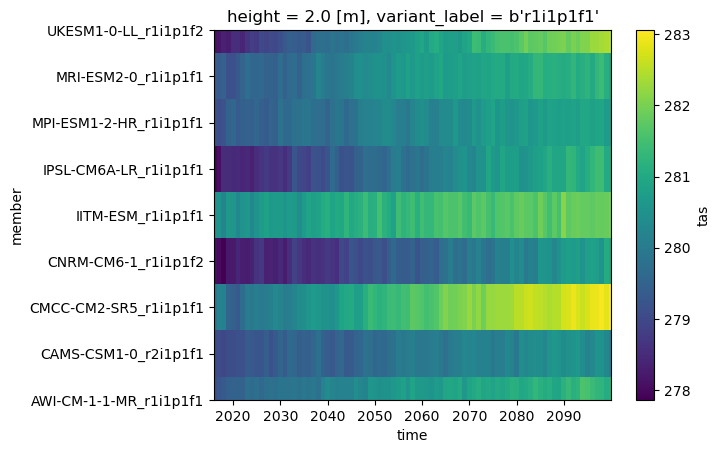

In [50]:
mean_ssp245.resample({"time": "YE"}).mean().plot()

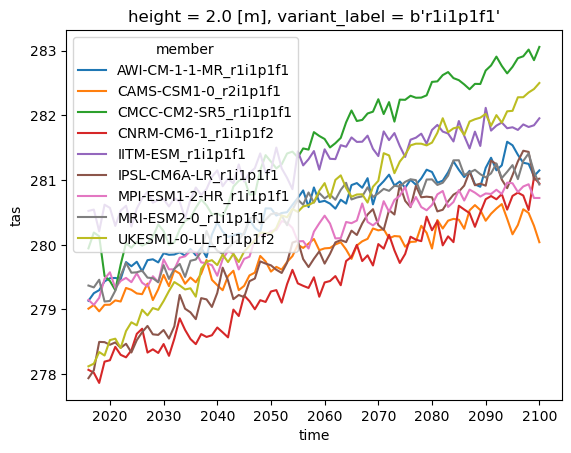

In [27]:
mean_ssp245.resample({"time": "YE"}).mean().plot.line(x="time")

In [44]:
m_ssp245_1995_2014 = (mean_ssp245 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member")
q_ssp245_1995_2014 = (mean_ssp245 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"])

m_ssp370_1995_2014 = (mean_ssp370 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member")
q_ssp370_1995_2014 = (mean_ssp370 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"])

m_ssp585_1995_2014 = (mean_ssp585 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member")
q_ssp585_1995_2014 = (mean_ssp585 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"])

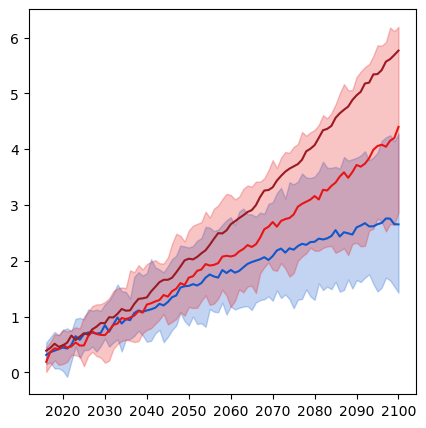

In [45]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(m_ssp245_1995_2014.time, m_ssp245_1995_2014, color="#0e57cc", label=f"SSP1-2.6  {len(mean_ssp126['member'])}")
ax.fill_between(q_ssp245_1995_2014.time,
                q_ssp245_1995_2014.sel(quantile=.05),
                q_ssp245_1995_2014.sel(quantile=.95),
                color="#0e57cc", alpha=0.25)
ax.plot(m_ssp370_1995_2014.time, m_ssp370_1995_2014, color="#e81515", label=f"SSP3-7.0  {len(mean_ssp370['member'])}")
ax.fill_between(q_ssp370_1995_2014.time,
                q_ssp370_1995_2014.sel(quantile=.05),
                q_ssp370_1995_2014.sel(quantile=.95),
                color="#e81515", alpha=0.25)
ax.plot(m_ssp585_1995_2014.time, m_ssp585_1995_2014, color="#9b1a22", label=f"SSP5-8.5  {len(mean_ssp585['member'])}")

#mean_hist_1995_2014_ye = mean_hist_1995_2014.resample({"time": "YE"}).mean()
# mean_ssp126_ye = (mean_ssp126 - mean_hist_1995_2014).resample({"time": "YE"}).mean()
# mean_ssp245_ye = (mean_ssp245 - mean_hist_1995_2014).resample({"time": "YE"}).mean()
# mean_ssp370_ye = (mean_ssp370 - mean_hist_1995_2014).resample({"time": "YE"}).mean()
# mean_ssp585_ye = (mean_ssp585 - mean_hist_1995_2014).resample({"time": "YE"}).mean()

#ax.plot(mean_hist_1995_2014_ye.time, mean_hist_1995_2014_ye.mean("member"), color="#010101", label=f"Historical  {len(hist['member'])}")
# ax.plot(mean_ssp126_ye.time, mean_ssp126_ye.mean("member"), color="#0e57cc", label=f"SSP1-2.6  {len(mean_ssp126_ye['member'])}")
# ax.plot(mean_ssp245_ye.time, mean_ssp245_ye.mean("member"), color="#e68d26", label=f"SSP2-4.5  {len(mean_ssp245_ye['member'])}")
# ax.plot(mean_ssp370_ye.time, mean_ssp370_ye.mean("member"), color="#e81515", label=f"SSP3-7.0  {len(mean_ssp370_ye['member'])}")
# ax.plot(mean_ssp585_ye.time, mean_ssp585_ye.mean("member"), color="#9b1a22", label=f"SSP5-8.5  {len(mean_ssp585_ye['member'])}")

# ytop = 6
#
# ax.fill_between(q_hist_1995_2014_YE.time,
#                 q_hist_1995_2014_YE.sel(quantile=.05),
#                 q_hist_1995_2014_YE.sel(quantile=.95),
#                 color="#616161", alpha=0.25)
# ax.fill_between(q_scenarios_1995_2014.sel(scenario="ssp126").time,
#                 q_scenarios_1995_2014.sel(scenario="ssp126").sel(quantile=.05),
#                 q_scenarios_1995_2014.sel(scenario="ssp126").sel(quantile=.95),
#                 color="#0e57cc", alpha=0.25)
# ax.fill_between(q_scenarios_1995_2014.sel(scenario="ssp370").time,
#                 q_scenarios_1995_2014.sel(scenario="ssp370").sel(quantile=.05),
#                 q_scenarios_1995_2014.sel(scenario="ssp370").sel(quantile=.95),
#                 color="#e81515", alpha=0.25)
# ax.set_ylim([-2, ytop])
# ax.set_ylabel("Relative to 1995-2014 (°C)")
# ax.axhline(y=0, color="black")
# ax.text(np.datetime64('2024-12-31T00:00:00.000000000'), -1, "Near\nterm")
# ax.text(np.datetime64('2044-12-31T00:00:00.000000000'), -1, "Mid\nterm")
# ax.text(np.datetime64('2084-12-31T00:00:00.000000000'), -1, "Long\nterm")

# ax2 = ax.twinx()
# ax2.plot(mean_hist_1850_1900_YE.time, mean_hist_1850_1900_YE.mean("member"), color="#010101", label=f"Historical  {len(hist['member'])}")
# ax2.plot(mean_scenarios_1850_1900.sel(scenario="ssp126").time, mean_scenarios_1850_1900.sel(scenario="ssp126").mean("member"), color="#0e57cc", label=f"SSP1-2.6  {len(ssp126['member'])}")
# ax2.plot(mean_scenarios_1850_1900.sel(scenario="ssp245").time, mean_scenarios_1850_1900.sel(scenario="ssp245").mean("member"), color="#e68d26", label=f"SSP2-4.5  {len(ssp245['member'])}")
# ax2.plot(mean_scenarios_1850_1900.sel(scenario="ssp370").time, mean_scenarios_1850_1900.sel(scenario="ssp370").mean("member"), color="#e81515", label=f"SSP3-7.0  {len(ssp370['member'])}")
# ax2.plot(mean_scenarios_1850_1900.sel(scenario="ssp585").time, mean_scenarios_1850_1900.sel(scenario="ssp585").mean("member"), color="#9b1a22", label=f"SSP5-8.5  {len(ssp585['member'])}")
# ax2.set_ylabel("Relative to 1850-1900 (°C)")
# ax2.set_ylim(bottom=-2+.82, top=ytop+.82)

# ax2.fill_between(
#     mean_scenarios_1995_2014.sel(scenario="ssp126")["time"].sel(time=slice("20200101", "20400101")),
#     -2+.82, ytop+.82, alpha=.33, color="grey")
# ax2.fill_between(
#     mean_scenarios_1995_2014.sel(scenario="ssp126")["time"].sel(time=slice("20400101", "20600101")),
#     -2+.82, ytop+.82, alpha=.33, color="grey")
# ax2.fill_between(
#     mean_scenarios_1995_2014.sel(scenario="ssp126")["time"].sel(time=slice("20800101", None)),
#     -2+.82, ytop+.82, alpha=.33, color="grey")

# ax.margins(0)
# ax2.margins(0)
# ax2.legend()

plt.savefig("t_CMIP6_scenarios.svg")

# Pangeo

In [139]:
pangeo_catalog = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
pangeo_catalog["version"] = pangeo_catalog["version"].astype(str)
pangeo_catalog.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [140]:
def find_model_runs_pangeo(pangeo_catalog, atlas_ipcc_catalog, model_runs, esgf_va_df, experiment):
    pangeo_model_runs = []
    
    for model, run in esgf_va_df.index.str.split("_"):
        # # descomentar cuando ejecute el notebook entero otra vez
        # # añadir a la lista de modelos ignorados al principio
        # if model in ["ACCESS-CM2","ACCESS-ESM1-5", "KIOST-ESM", "MPI-ESM-1-2-HAM"]:
        #     continue
        model_run = "_".join([model, run])
        if model_run not in esgf_va_df.index or (model_run in esgf_va_df.index and esgf_va_df.loc[model_run, experiment] is np.nan):
            continue

        version = atlas_ipcc_catalog.query(f"model == '{model}' & experiment == '{experiment}' & member == '{run}' & variable == 'tas'")["version"].iloc[0][1:]
        subset = pangeo_catalog.query(f"source_id == '{model}' & table_id == 'day' & variable_id == 'tas' & experiment_id == '{experiment}' & member_id == '{run}' & version == '{version}'").set_index(["source_id", "experiment_id", "version"]).drop(["variable_id"], axis=1)

        url = subset["zstore"].iloc[0]
        record = {"url": url, "model_run": model + "_" + model_runs[model]}
        pangeo_model_runs.append(record)

    return pd.DataFrame.from_records(pangeo_model_runs)

In [141]:
ssp585_model_runs_pangeo = find_model_runs_pangeo(pangeo_catalog, atlas_ipcc_catalog, model_runs, df, "ssp585").set_index("model_run").rename({"url": "ssp585"}, axis=1)
historical_model_runs_pangeo = find_model_runs_pangeo(pangeo_catalog, atlas_ipcc_catalog, model_runs, df, "historical").set_index("model_run").rename({"url": "historical"}, axis=1)

In [142]:
df_pangeo = historical_model_runs_pangeo.join(ssp585_model_runs_pangeo)
df_pangeo

,historical,ssp585
model_run,,
AWI-CM-1-1-MR_r1i1p1f1,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...
CAMS-CSM1-0_r2i1p1f1,gs://cmip6/CMIP6/CMIP/CAMS/CAMS-CSM1-0/histori...,gs://cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/...
CanESM5_r1i1p1f1,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...
CESM2-WACCM_r1i1p1f1,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/...
CMCC-CM2-SR5_r1i1p1f1,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/histor...,gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5...
CNRM-CM6-1_r1i1p1f2,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...
CNRM-CM6-1-HR_r1i1p1f2,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1-...,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...
CNRM-ESM2-1_r1i1p1f2,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...
GFDL-CM4_r1i1p1f1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN


In [143]:
def load_datasets_pangeo(locations, members, experiment):
    dss = []
    for location in locations:
        if location is np.nan:
            continue

        model = location.split("/")[6]

        ds = xarray.open_zarr(
            location,
            drop_variables=["time_bnds", "lat_bnds", "lon_bnds"])

        if experiment == "ssp585":
            ds = ds.isel(time=slice(None, 31390))
            # limit to 2100, avoid cf time indexing issues
            if isinstance(ds["time"][0].item(), cftime.Datetime360Day):
                ds = ds.sel(time=slice("20150101", "21001230"))
            else:
                ds = ds.sel(time=slice("20150101", "21001231"))
        elif experiment == "historical":
            pass
        else:
            raise ValueError("Invalid experiment... exiting")
    
        # add the model_run global attribute
        ds.attrs["model_run"] = f"{model}_{members[model]}"
        dss.append(ds)

    return dss

In [144]:
historical_dss_pangeo = load_datasets_pangeo(df_pangeo["historical"], model_runs, "historical")
ssp585_dss_pangeo = load_datasets_pangeo(df_pangeo["ssp585"], model_runs, "ssp585")

/tmp/ipykernel_1397283/22478155.py:9: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xarray.open_zarr(


In [21]:
for ds in ssp585_dss_pangeo:
    print(f'{ds["tas"].size * ds["tas"].dtype.itemsize / 2**20:.2f} MB')

8828.44 MB
6063.67 MB
980.94 MB
6621.33 MB
6621.33 MB
3923.75 MB
31037.48 MB
3923.75 MB
15695.00 MB
3265.31 MB
2137.44 MB
2465.76 MB
8828.44 MB
1655.33 MB
6621.33 MB


In [57]:
import time

ssp585 con weights 40 min y 63.6 GB.

ssp585 con weights optimizados 32 min.

In [92]:
%%time

ssp585_spatial_mean_pangeo = []
for ds in ssp585_dss_pangeo:
    print(ds.attrs["model_run"])
    t0 = time.time()
    weights = np.cos(np.deg2rad(ds["lat"]))
    t1 = time.time()
    print(f"weights {t1-t0}")
    # spatial_mean = ds["tas"].weighted(weights).mean(["lat", "lon"]).compute(num_workers=8, scheduler="processes")
    spatial_mean = wmean(ds["tas"]).compute(num_workers=8, scheduler="processes")
    t2 = time.time()
    print(f"mean {t2-t1}")
    ssp585_spatial_mean_pangeo.append(spatial_mean)

AWI-CM-1-1-MR_r1i1p1f1
weights 0.00054168701171875
mean 182.459979057312
CAMS-CSM1-0_r2i1p1f1
weights 0.0007009506225585938
mean 58.06053614616394
CanESM5_r1i1p1f1
weights 0.0009217262268066406
mean 41.08850049972534
CESM2-WACCM_r1i1p1f1
weights 0.0015704631805419922
mean 135.95794034004211
CMCC-CM2-SR5_r1i1p1f1
weights 0.0016453266143798828
mean 61.762778997421265
CNRM-CM6-1_r1i1p1f2
weights 0.0006203651428222656
mean 87.11399698257446
CNRM-CM6-1-HR_r1i1p1f2
weights 0.00182342529296875
mean 548.5553567409515
CNRM-ESM2-1_r1i1p1f2
weights 0.0018527507781982422
mean 96.40805506706238
EC-Earth3_r1i1p1f1
weights 0.0015490055084228516
mean 301.4683313369751
HadGEM3-GC31-LL_r1i1p1f3
weights 0.0017561912536621094
mean 40.07858920097351
IITM-ESM_r1i1p1f1
weights 0.0031197071075439453
mean 34.068946838378906
IPSL-CM6A-LR_r1i1p1f1
weights 0.001710653305053711
mean 63.85861325263977
MPI-ESM1-2-HR_r1i1p1f1
weights 0.0015990734100341797
mean 168.88255882263184
NorESM2-LM_r1i1p1f1
weights 0.00063300

98.5 GB (TX) y 41min 33s.

In [93]:
%%time

ssp585_spatial_mean = []
for ds in ssp585_dss:
    print(ds.attrs["model_run"])
    t0 = time.time()
    weights = np.cos(np.deg2rad(ds["lat"]))
    t1 = time.time()
    print(f"weights {t1-t0}")
    spatial_mean = wmean(ds["tas"].chunk({"time": 100})).compute(num_workers=8, scheduler="processes")
    t2 = time.time()
    print(f"mean {t2-t1}")
    ssp585_spatial_mean.append(spatial_mean)

AWI-CM-1-1-MR_r1i1p1f1
weights 0.0006108283996582031
mean 175.8067467212677
CAMS-CSM1-0_r2i1p1f1
weights 0.003901958465576172
mean 121.75541973114014
CanESM5_r1i1p1f1
weights 0.0010330677032470703
mean 28.82766366004944
CESM2-WACCM_r1i1p1f1
weights 0.0009326934814453125
mean 138.48325276374817
CMCC-CM2-SR5_r1i1p1f1
weights 0.0024781227111816406
mean 140.38412022590637
CNRM-CM6-1_r1i1p1f2
weights 0.0017316341400146484
mean 79.16581439971924
CNRM-CM6-1-HR_r1i1p1f2
weights 0.0019354820251464844
mean 617.4415581226349
CNRM-ESM2-1_r1i1p1f2
weights 0.0008225440979003906
mean 81.84999465942383
EC-Earth3_r1i1p1f1
weights 0.0017147064208984375
mean 132.6526222229004
HadGEM3-GC31-LL_r1i1p1f3
weights 0.001201629638671875
mean 69.59553670883179
IITM-ESM_r1i1p1f1
weights 0.0006911754608154297
mean 47.444971561431885
IPSL-CM6A-LR_r1i1p1f1
weights 0.0008172988891601562
mean 56.02434015274048
MPI-ESM1-2-HR_r1i1p1f1
weights 0.0007650852203369141
mean 179.94435238838196
NorESM2-LM_r1i1p1f1
weights 0.001

Ver cuanto tardaron.

# Test de uno

In [145]:
a = ssp585_dss[0]["tas"].chunk({"time": 100})
b = ssp585_dss_pangeo[0]["tas"]

In [146]:
a

<xarray.DataArray 'tas' (time: 31046, lat: 192, lon: 384)> Size: 9GB
dask.array<xarray-<this-array>, shape=(31046, 192, 384), dtype=float32, chunksize=(100, 192, 384), chunktype=numpy.ndarray>
Coordinates:
  * lat            (lat) float64 2kB -89.28 -88.36 -87.42 ... 87.42 88.36 89.28
  * lon            (lon) float64 3kB 0.0 0.9375 1.875 ... 357.2 358.1 359.1
    height         float64 8B ...
  * time           (time) datetime64[ns] 248kB 2015-01-01T12:00:00 ... 2099-1...
    variant_label  |S64 64B b'r1i1p1f1'
Attributes:
    long_name:        Near-Surface Air Temperature
    _CoordinateAxes:  variant_label height time lat lon
    standard_name:    air_temperature
    comment:          near-surface (usually, 2 meter) air temperature
    units:            K
    original_name:    temp2
    cell_methods:     area: time: mean
    cell_measures:    area: areacella
    history:          2019-07-28T13:16:55Z altered by CMOR: Treated scalar di...
    _ChunkSizes:      [  1 192 384]

In [147]:
b

<xarray.DataArray 'tas' (time: 31390, lat: 192, lon: 384)> Size: 9GB
dask.array<getitem, shape=(31390, 192, 384), dtype=float32, chunksize=(221, 192, 384), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B ...
  * lat      (lat) float64 2kB -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * time     (time) datetime64[ns] 251kB 2015-01-01T12:00:00 ... 2100-12-10T1...
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    history:        2019-06-09T22:59:57Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    original_name:  temp2
    standard_name:  air_temperature
    units:          K

In [150]:
%%time

a.mean(["lat", "lon"]).compute(num_workers=8, scheduler="processes")

CPU times: user 298 ms, sys: 44.6 ms, total: 343 ms
Wall time: 3min 39s


<xarray.DataArray 'tas' (time: 31046)> Size: 124kB
array([277.514  , 277.61942, 277.68872, ..., 283.26273, 283.34238,
       283.4442 ], dtype=float32)
Coordinates:
    height         float64 8B 2.0
  * time           (time) datetime64[ns] 248kB 2015-01-01T12:00:00 ... 2099-1...
    variant_label  |S64 64B b'r1i1p1f1'

1min 14s y 5.34GB

In [151]:
%%time

b.mean(["lat", "lon"]).compute(num_workers=8, scheduler="processes")

CPU times: user 185 ms, sys: 29.3 ms, total: 214 ms
Wall time: 1min 14s


<xarray.DataArray 'tas' (time: 31390)> Size: 126kB
array([277.514  , 277.61942, 277.68872, ..., 283.17105, 283.20245,
       283.20184], dtype=float32)
Coordinates:
    height   float64 8B 2.0
  * time     (time) datetime64[ns] 251kB 2015-01-01T12:00:00 ... 2100-12-10T1...

In [107]:
def wmean(da):
    weights = np.cos(np.deg2rad(da['lat']))
    weights /= weights.sum()
    weights_2d = weights.broadcast_like(da.isel(time=0)).load()
    weighted_mean = (da * weights_2d).sum(dim=('lat', 'lon')) / weights_2d.sum(dim=('lat', 'lon'))

    return weighted_mean

17 GB y 4min 34s.

In [101]:
%%time

wmean(a).compute(num_workers=8, scheduler="processes")

CPU times: user 1.59 s, sys: 221 ms, total: 1.81 s
Wall time: 4min 34s


<xarray.DataArray (time: 31390)> Size: 251kB
array([286.19583748, 286.19269661, 286.21112892, ..., 290.57798724,
       290.6187887 , 290.6049733 ])
Coordinates:
    height         float64 8B 2.0
  * time           (time) datetime64[ns] 251kB 2015-01-01T12:00:00 ... 2100-1...
    variant_label  |S64 64B b'r1i1p1f1'

2min 45s y 5.34 GB (xq ha subido de 1min 14s?)

In [108]:
%%time

wmean(b).compute(num_workers=8, scheduler="processes")

CPU times: user 26.6 s, sys: 1min 20s, total: 1min 47s
Wall time: 2min 43s


<xarray.DataArray (time: 31390)> Size: 251kB
array([286.19583748, 286.19269661, 286.21112892, ..., 290.57798724,
       290.6187887 , 290.6049733 ])
Coordinates:
    height   float64 8B 2.0
  * time     (time) datetime64[ns] 251kB 2015-01-01T12:00:00 ... 2100-12-10T1...

La weighted de xarray?

In [149]:
%%time

weights = np.cos(np.deg2rad(a['lat']))
y = a.weighted(weights).mean(["lat", "lon"]).compute(num_workers=8, scheduler="processes")

CPU times: user 30.4 s, sys: 47.3 s, total: 1min 17s
Wall time: 4min 8s


In [148]:
%%time

weights = np.cos(np.deg2rad(b['lat']))
x = b.weighted(weights).mean(["lat", "lon"]).compute(num_workers=8, scheduler="processes")

CPU times: user 39.7 s, sys: 1min 48s, total: 2min 28s
Wall time: 3min 6s


In [94]:
for ds in ssp585_dss_pangeo:
    print(f'{ds["tas"].size * ds["tas"].dtype.itemsize / 2**20:.2f} MB')

8828.44 MB
6063.67 MB
980.94 MB
6621.33 MB
6621.33 MB
3923.75 MB
31037.48 MB
3923.75 MB
15695.00 MB
3265.31 MB
2137.44 MB
2465.76 MB
8828.44 MB
1655.33 MB
6621.33 MB


In [95]:
for ds in ssp585_dss:
    print(f'{ds["tas"].size * ds["tas"].dtype.itemsize / 2**20:.2f} MB')

8828.44 MB
6063.67 MB
980.94 MB
6621.33 MB
6621.33 MB
3923.75 MB
31037.48 MB
3923.75 MB
5479.50 MB
3265.31 MB
2137.44 MB
2465.76 MB
8828.44 MB
1655.33 MB
6621.33 MB


# Mi weighted es de verdad weighted?

Probando para ver si el unweighted tiene sentido o no... De hecho mi weighted está mal para el historico, volver a correr.

In [111]:
def wmean(da, dims):
    weights = np.cos(np.deg2rad(da["lat"]))
    weighted_mean = da.weighted(weights).mean(dims)

    return weighted_mean

Test to see quartiles:

In [112]:
%%time

historicalw2_spatial_mean_1995_2014 = []
for ds in historical_dss:
    print(f"Model_run: {ds.attrs['model_run']}")
    if isinstance(ds["time"][0].item(), cftime.Datetime360Day):
        mean_1995_2014 = wmean(ds["tas"].chunk({"time": 100}).sel(time=slice("19950101", "20141230")), ("time", "lat", "lon")).compute(num_workers=8, scheduler="processes")
    else:
        mean_1995_2014 = wmean(ds["tas"].chunk({"time": 100}).sel(time=slice("19950101", "20141231")), ("time", "lat", "lon")).compute(num_workers=8, scheduler="processes")

    historicalw2_spatial_mean_1995_2014.append(mean_1995_2014)

Model_run: AWI-CM-1-1-MR_r1i1p1f1
Model_run: CAMS-CSM1-0_r2i1p1f1
Model_run: CanESM5_r1i1p1f1
Model_run: CESM2-WACCM_r1i1p1f1
Model_run: CMCC-CM2-SR5_r1i1p1f1
Model_run: CNRM-CM6-1_r1i1p1f2
Model_run: CNRM-CM6-1-HR_r1i1p1f2
Model_run: CNRM-ESM2-1_r1i1p1f2
Model_run: GFDL-CM4_r1i1p1f1
Model_run: GFDL-ESM4_r1i1p1f1
Model_run: HadGEM3-GC31-LL_r1i1p1f3
Model_run: IITM-ESM_r1i1p1f1
Model_run: INM-CM4-8_r1i1p1f1
Model_run: INM-CM5-0_r1i1p1f1
Model_run: IPSL-CM6A-LR_r1i1p1f1
Model_run: MIROC6_r1i1p1f1
Model_run: MPI-ESM1-2-HR_r1i1p1f1
Model_run: MPI-ESM1-2-LR_r1i1p1f1
Model_run: MRI-ESM2-0_r1i1p1f1
Model_run: NorESM2-LM_r1i1p1f1
Model_run: NorESM2-MM_r1i1p1f1
Model_run: TaiESM1_r1i1p1f1
Model_run: UKESM1-0-LL_r1i1p1f2
CPU times: user 3min 16s, sys: 4min 49s, total: 8min 6s
Wall time: 19min 42s


In [95]:
%%time

ssp126w2_spatial_mean = []
for ds in ssp126_dss:
    print(f"Model_run: {ds.attrs['model_run']}")
    spatial_mean = wmean(ds["tas"].chunk({"time": 100}), ("lat", "lon")).compute(num_workers=8, scheduler="processes")
    spatial_mean = spatial_mean.convert_calendar("gregorian", align_on="year")
    spatial_mean = spatial_mean.isel(time=~pd.to_datetime(spatial_mean["time"].values, errors="coerce").isna())
    spatial_mean["time"] = spatial_mean["time"].astype("datetime64[ns]")
    ssp126w2_spatial_mean.append(spatial_mean)

Model_run: AWI-CM-1-1-MR_r1i1p1f1
Model_run: CAMS-CSM1-0_r2i1p1f1
Model_run: CMCC-CM2-SR5_r1i1p1f1
Model_run: CNRM-CM6-1_r1i1p1f2
Model_run: CNRM-ESM2-1_r1i1p1f2
Model_run: GFDL-ESM4_r1i1p1f1
Model_run: IITM-ESM_r1i1p1f1
Model_run: IPSL-CM6A-LR_r1i1p1f1
Model_run: MIROC6_r1i1p1f1
Model_run: MPI-ESM1-2-HR_r1i1p1f1
Model_run: MPI-ESM1-2-LR_r1i1p1f1
Model_run: UKESM1-0-LL_r1i1p1f2
CPU times: user 4min, sys: 4min 45s, total: 8min 46s
Wall time: 23min 34s


In [128]:
%%time

ssp585w2_spatial_mean = []
for ds in ssp585_dss:
    print(f"Model_run: {ds.attrs['model_run']}")
    spatial_mean = wmean(ds["tas"].chunk({"time": 100}), ("lat", "lon")).compute(num_workers=8, scheduler="processes")
    spatial_mean = spatial_mean.convert_calendar("gregorian", align_on="year")
    spatial_mean = spatial_mean.isel(time=~pd.to_datetime(spatial_mean["time"].values, errors="coerce").isna())
    spatial_mean["time"] = spatial_mean["time"].astype("datetime64[ns]")
    ssp585w2_spatial_mean.append(spatial_mean)

Model_run: AWI-CM-1-1-MR_r1i1p1f1
Model_run: CAMS-CSM1-0_r2i1p1f1
Model_run: CanESM5_r1i1p1f1
Model_run: CESM2-WACCM_r1i1p1f1
Model_run: CMCC-CM2-SR5_r1i1p1f1
Model_run: CNRM-CM6-1_r1i1p1f2
Model_run: CNRM-CM6-1-HR_r1i1p1f2
Model_run: CNRM-ESM2-1_r1i1p1f2
Model_run: HadGEM3-GC31-LL_r1i1p1f3
Model_run: IITM-ESM_r1i1p1f1
Model_run: IPSL-CM6A-LR_r1i1p1f1
Model_run: MPI-ESM1-2-HR_r1i1p1f1
Model_run: NorESM2-LM_r1i1p1f1
Model_run: TaiESM1_r1i1p1f1
CPU times: user 6min 4s, sys: 8min 43s, total: 14min 47s
Wall time: 48min 49s


In [131]:
mean_histw2_1995_2014 = xarray.DataArray(
    data=[x.item() for x in historicalw2_spatial_mean_1995_2014],
    coords={"member": [x.attrs["model_run"] for x in historical_dss]})

mean_ssp126w2 = xarray.concat(
    ssp126w2_spatial_mean,
    dim=xarray.DataArray([x.attrs["model_run"] for x in ssp126_dss], dims="member"),
    coords="minimal",
    compat="override")

mean_ssp585w2 = xarray.concat(
    ssp585w2_spatial_mean,
    dim=xarray.DataArray([x.attrs["model_run"] for x in ssp585_dss], dims="member"),
    coords="minimal",
    compat="override")

In [134]:
m_ssp126w2 = (mean_ssp126w2 - mean_histw2_1995_2014).resample({"time": "YE"}).mean().mean("member")
q_ssp126w2 = (mean_ssp126w2 - mean_histw2_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"])

m_ssp585w2 = (mean_ssp585w2 - mean_histw2_1995_2014).resample({"time": "YE"}).mean().mean("member")
q_ssp585w2 = (mean_ssp585w2 - mean_histw2_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"])

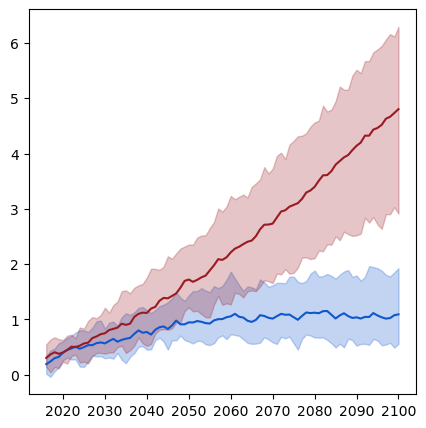

In [136]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(m_ssp126w2.time, m_ssp126w2, color="#0e57cc", label=f"SSP1-2.6  {len(mean_ssp126w2['member'])}")
ax.fill_between(q_ssp126w2.time,
                q_ssp126w2.sel(quantile=.05),
                q_ssp126w2.sel(quantile=.95),
                color="#0e57cc", alpha=0.25)

ax.plot(m_ssp585w2.time, m_ssp585w2, color="#9b1a22", label=f"SSP1-2.6  {len(mean_ssp585w2['member'])}")
ax.fill_between(q_ssp585w2.time,
                q_ssp585w2.sel(quantile=.05),
                q_ssp585w2.sel(quantile=.95),
                color="#9b1a22", alpha=0.25)

#plt.savefig("t_CMIP6_scenarios.svg")

# modulo gsat

In [10]:
from gsat import weighted

In [11]:
%%time

mean_hist_1995_2014, mean_hist_1850_1900, hist_spatial_mean, mean_ssp126, mean_ssp245, mean_ssp370, mean_ssp585 = weighted(
    8,
    historical_dss, ssp126_dss, ssp245_dss, ssp370_dss, ssp585_dss)

Model_run: AWI-CM-1-1-MR_r1i1p1f1
Model_run: CAMS-CSM1-0_r2i1p1f1
Model_run: CanESM5_r1i1p1f1
Model_run: CESM2-WACCM_r1i1p1f1
Model_run: CMCC-CM2-SR5_r1i1p1f1
Model_run: CNRM-CM6-1_r1i1p1f2
Model_run: CNRM-CM6-1-HR_r1i1p1f2
Model_run: CNRM-ESM2-1_r1i1p1f2
Model_run: GFDL-CM4_r1i1p1f1
Model_run: GFDL-ESM4_r1i1p1f1
Model_run: HadGEM3-GC31-LL_r1i1p1f3
Model_run: IITM-ESM_r1i1p1f1
Model_run: INM-CM4-8_r1i1p1f1
Model_run: INM-CM5-0_r1i1p1f1
Model_run: IPSL-CM6A-LR_r1i1p1f1
Model_run: MIROC6_r1i1p1f1
Model_run: MPI-ESM1-2-HR_r1i1p1f1
Model_run: MPI-ESM1-2-LR_r1i1p1f1
Model_run: MRI-ESM2-0_r1i1p1f1
Model_run: NorESM2-LM_r1i1p1f1
Model_run: NorESM2-MM_r1i1p1f1
Model_run: TaiESM1_r1i1p1f1
Model_run: UKESM1-0-LL_r1i1p1f2
CPU times: user 36min 43s, sys: 58min 42s, total: 1h 35min 25s
Wall time: 4h 57min 26s


In [12]:
m_ssp126 = (mean_ssp126 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member")
q_ssp126 = (mean_ssp126 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"])

m_ssp370 = (mean_ssp370 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member")
q_ssp370 = (mean_ssp370 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"])

m_ssp585 = (mean_ssp585 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member")
q_ssp585 = (mean_ssp585 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"])

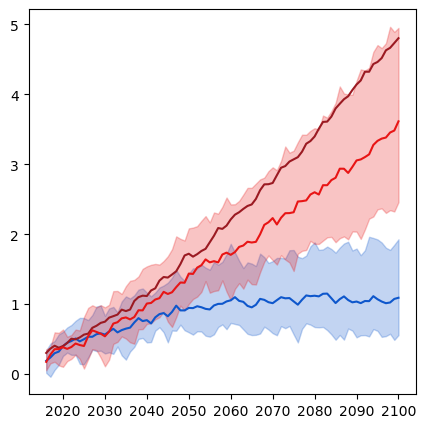

In [13]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(m_ssp126.time, m_ssp126, color="#0e57cc", label=f"SSP1-2.6  {len(mean_ssp126['member'])}")
ax.fill_between(q_ssp126.time,
                q_ssp126.sel(quantile=.05),
                q_ssp126.sel(quantile=.95),
                color="#0e57cc", alpha=0.25)

ax.plot(m_ssp585.time, m_ssp585, color="#9b1a22", label=f"SSP5-8.5  {len(mean_ssp585['member'])}")

ax.plot(m_ssp370.time, m_ssp370, color="#e81515", label=f"SSP3-7.0  {len(mean_ssp370['member'])}")
ax.fill_between(q_ssp370.time,
                q_ssp370.sel(quantile=.05),
                q_ssp370.sel(quantile=.95),
                color="#e81515", alpha=0.25)